# HW12 - Watershed

## Model Description 
This constructs a 2D steady state box model with a single stream reach
#### Dimensions: 
- 50 by 50 by 1 (note the odd number so that the stream can be centered)
- dx = dy = 100 m
- dz = 5 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x, y and z.
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient=0.0001  

#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.0001 m/m
- Streambed rough = 0.02377
- Streambed width = 20 m
- Streambed K = 8.5 m/day for the rows 0-8, 0.1 for rows 8-9, and 1 for the rest of the stream. 
- Streambed thickness = 1 m
- Stream bottom depth = 7 m

#### Boundary Conditions: 
 - Right boundary is defined head representing a stream that runs 'down' the domain - in the direction of increasing row number.
 - Left boundary is a constant head representing a lake.

# Set up the environment

In [66]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

#additional analysis tools
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv


#jupyter specific--included to show plots in notebook
%matplotlib inline

# User inputs

In [67]:
modelname = "HW12_Watershed"
moddir="../../mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir) #creating a new object to apply the packages to it

#Horizontal Discretization
nrow = 50
ncol = 50
dx = 100
dy = 100
Lx = dx*ncol
Ly = dy*nrow

#Vertical Discretization
nlay = 3

#reading the topography
with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
zbot = 0. #bottom elevation
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 35 m RELATIVE to the bottom of the domain
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m RELATIVE to the bottom of the domain


## Timing
nper = 1   #number of stress periods 
steady = [True] #list noting the stress period type

#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)

K_horiz = 8.5    #assign horizontal hydraulic conductivity (along x and y axis)
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)


# Setup the MODFLOW Packages other than the stream package

In [68]:

#Create bas object. Boundary and initial conditions
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active
ibound[:, 0, :] = 0                                 #replace top border row (all zs, all ys, first x) with 0 to indicate no flow
ibound[:, -1, :] = 0                                 #replace top border row (all zs, all ys, first x) with 0 to indicate no flow
ibound[:, :, 0] = 0                                 #replace leftmost column (all zs, all ys, first x) with 0 to indicate no flow
ibound[:, :, -1] = -1                               #replace rightmost column (all zs, all ys, first x) with <0 to indicate active cell with constant head
#Top-Left Triangle of top layer
ibound[0,0,0:6] = 0
ibound[0,1,0:5] = 0
ibound[0,2,0:4] = 0
ibound[0,3,0:3] = 0
ibound[0,4,0:2] = 0
ibound[0,5,0] = 0
#Top-LeftTriangle of Middle layer
ibound[1,0,0:8] = 0
ibound[1,1,0:7] = 0
ibound[1,2,0:6] = 0
ibound[1,3,0:5] = 0
ibound[1,4,0:4] = 0
ibound[1,5,0:3] = 0
ibound[1,6,0:2] = 0
ibound[1,7,0] = 0
#Top-LeftTriangle of Bottom layer
ibound[2,0,0:10] = 0
ibound[2,1,0:9] = 0
ibound[2,2,0:8] = 0
ibound[2,3,0:7] = 0
ibound[2,4,0:6] = 0
ibound[2,5,0:5] = 0
ibound[2,6,0:4] = 0
ibound[2,7,0:3] = 0
ibound[2,8,0:2] = 0
ibound[2,9,0] = 0

#Bottom-Left Triangle of top layer
ibound[0,44,0] = 0
ibound[0,45,0:2] = 0
ibound[0,46,0:3] = 0
ibound[0,47,0:4] = 0
ibound[0,48,0:5] = 0
ibound[0,49,0:6] = 0
#Bottom-LeftTriangle of Middle layer
ibound[1,41,0] = 0
ibound[1,42,0:1] = 0
ibound[1,43,0:2] = 0
ibound[1,44,0:3] = 0
ibound[1,45,0:4] = 0
ibound[1,46,0:5] = 0
ibound[1,47,0:6] = 0
ibound[1,48,0:7] = 0
ibound[1,49,0:8] = 0
#Bottom-LeftTriangle of Bottom layer
ibound[2,40,0] = 0
ibound[2,41,0:2] = 0
ibound[2,42,0:3] = 0
ibound[2,43,0:4] = 0
ibound[2,44,0:5] = 0
ibound[2,45,0:6] = 0
ibound[2,46,0:7] = 0
ibound[2,47,0:8] = 0
ibound[2,48,0:9] = 0
ibound[2,49,0:10] = 0


strt = np.ones((nlay, nrow, ncol), dtype=np.float32)  
strt[:, 0:50, 0] = 0.5                                    #create strt as array of floats 
strt[:, 0:50, -1] = np.linspace(10,3,50)                 #create strt as array of floats 

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

# Plot model grid and boundary conditions

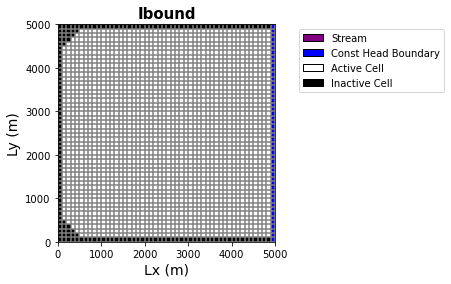

In [69]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
#str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

In [70]:

#LPF object. Layer properties
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

hk[:,:,:] = hk*K_horiz           #Horizontal hydraulic conductivity for the 2 top layer
vk[:,:,:] = vk*K_vert           #Horizontal hydraulic conductivity for the 2 top layer
vk[1,:,21:50] = 2.1e-2*K_horiz         #Vertical hydraulic conductivity for the lower layer

ss = np.ones((nlay,nrow,ncol), dtype=np.float)          #define specific storage
ss[:,:,:] = 1e-4                                        #Storage Coefficient
n = 0.1                                                 #Porosity
Sy = 0.884                                              #Specific Yield
uncnf = 1

lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=hk, 
                               vka=vk, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

# Rch object
recharge = 4e-5 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:16]=rech_zone[:,0:16]+recharge
#rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

## Well
pumping = -50 #m3/day  #given
well_loc = (2,21,38) #Well loc should be layer, row, column
well = [i for i in well_loc] + [pumping]
print(well)
print("Well 1 [layer, row, column, flux]: \n", well)
wel_spd = {0: [well]} #putting the well in the bottom layer
#wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)


## Boundary conditions
h_right = 70
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, -1] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#create  output control object. create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
#pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=2000, relax = 0.7, damp = 0.7)

#write the inputs
m.write_input()    

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_7304\1545043605.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)          #define specific storage


[2, 21, 38, -50]
Well 1 [layer, row, column, flux]: 
 [2, 21, 38, -50]
FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: HW12_Watershed.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/18  8:39:57

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.


Exception: MODFLOW did not terminate normally.

# Setup the stream! Define STR object

In [ ]:
# User inputs:
k_strbott = 1.36*hk[0,25,25]                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
str_bott = 7                       #river bottom
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                        #roughness of streambed
width = 1.                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day (no water inn in our top of our domain)
Stage_above_datum = 9 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values for streambed conductance
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
cond_vals[0:20] = cond/100
cond_vals[21:26] = cond/10
cond_vals[27:-1] = cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []
for x in range(nrow): #layer, row, column: layer=0, row=x, column=nrow/2, 1 is the segment. x+1 is the reach (they have to order from upstream to downstream)
    add = [0, x, ncol/2, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

Calculated stage at inflow = 8.0


# Write MODFLOW input files and run the model

In [ ]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: HW12_Watershed.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/15 20:45:20

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/15 20:45:20
 Elapsed run time:  0.502 Seconds

  Normal termination of simulation


# Plotting
### Cross section plots

In [ ]:
#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


# Plot stream related results 

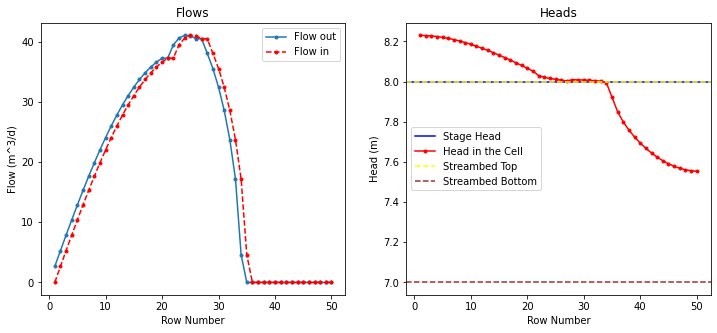

In [ ]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
leakage = leak[0]
str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='.') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='.') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()

#####################################################################
# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='.') 
ax2.axhline(y=str_top,  color='yellow', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()

# Plot head distribution

C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


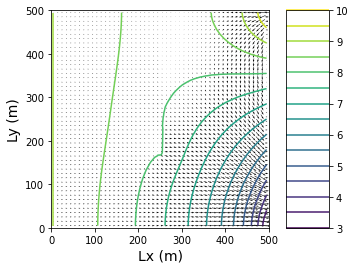

In [ ]:
#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)